In [1]:
# Prototype for gain estimation using empirical risk minimization according to
# Radhakrishnan, A., & Meyn, S. (2018). Feedback Particle Filter Design Using a Differential-Loss Reproducing Kernel Hilbert Space. In 2018 Annual American Control Conference (ACC) (pp. 329–336). IEEE. https://doi.org/10.23919/ACC.2018.8431689
# for the gain of the feedback particle filter:
# Yang, T., Mehta, P. G., & Meyn, S. P. (2013). Feedback Particle Filter. IEEE Transactions on Automatic Control, 58(10), 2465–2480. https://doi.org/10.1109/TAC.2013.2258825

In [2]:
# This program approximates the solution grad h of the Poisson equation div(p*grad h)=-\tilde{c}p

In [3]:
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from autograd import grad

In [4]:
# compute optimal gain at y from samples and beta vector (derivative of Eq. 21)
# K = g', where g is the approximation of the solution h of the Poisson equation
def Gain_ERM(y,samples,beta):
    N=len(samples)
    return beta[:N].dot(Ky(samples,y))+beta[N:].dot(Kxy(samples,y))

# compute beta vector from samples (Eq. 22)
def OptimalBeta(samples,lamb):
    N=len(samples)
    
    # empirical observation function
    zeta=c(samples)
    zeta=zeta-np.average(zeta)
    
    # kernel Gram matrices
    K0mat=K(samples[:,None],samples)
    Kxmat=Kx(samples[:,None],samples)
    Kymat=Ky(samples[:,None],samples)
    Kxymat=Kxy(samples[:,None],samples)
    
    # compute M and b
    M=1/N*np.dot(
            np.concatenate((Kymat,Kxymat),axis=0),
            np.concatenate((Kxmat,Kxymat),axis=1)
    )+lamb*np.concatenate((
            np.concatenate((K0mat,Kxmat),axis=0),
            np.concatenate((Kymat,Kxymat),axis=0)
    ),axis=1
    )
    b=1/N*np.concatenate((K0mat,Kxmat),axis=0).dot(zeta)
    return np.linalg.solve(M,b) # solve equation M.beta=b

# Directly compute the gain at the sample locations
# input: sample locations
# output: gain function evaluated at the sample locations
def Gain_ERM_direct(samples,lambd):
    N=len(samples)
    
    # empirical observation function
    zeta=c(samples)
    zeta=zeta-np.average(zeta)
    
    # kernel Gram matrices
    K0mat=K(samples[:,None],samples)
    Kxmat=Kx(samples[:,None],samples)
    Kymat=Ky(samples[:,None],samples)
    Kxymat=Kxy(samples[:,None],samples)
    
    # compute M and b
    M=1/N*np.dot(
            np.concatenate((Kymat,Kxymat),axis=0),
            np.concatenate((Kxmat,Kxymat),axis=1)
    )+lamb*np.concatenate((
            np.concatenate((K0mat,Kxmat),axis=0),
            np.concatenate((Kymat,Kxymat),axis=0)
    ),axis=1
    )
    b=1/N*np.concatenate((K0mat,Kxmat),axis=0).dot(zeta)
    beta=np.linalg.solve(M,b) # solve equation M.beta=b
    return beta[:N].dot(Kymat)+beta[N:].dot(Kxymat)

In [5]:
# 
#
# Main code, settings

In [6]:
# Observation function c
def c(x):
    s=1000.
    return 1/2*(np.tanh(s*(x+.5))-np.tanh(s*(x+1.5))+np.tanh(s*(x-.5))-np.tanh(s*(x-1.5)))

# Density p
def p(x):
    return np.average([np.exp(-(x-x0)**2/(2*0.04))/np.sqrt(2*np.pi*0.04) for x0 in range(-2,3,1)])

# kernel for RKHS and its derivatives
def K(x,y):
    return np.exp(-(x-y)**2/(2*eps))

def Kx(x,y):
    return (y-x)*K(x,y)/eps

def Ky(x,y):
    return (x-y)*K(x,y)/eps

def Kxy(x,y):
    return (eps-(x-y)**2)*K(x,y)/(eps**2)

eps=.05
lamb=10e-3

In [7]:
n_samples=100
x=np.concatenate([x0+0.2*np.random.randn(n_samples) for x0 in range(-2,3,1)]) # generate particles from p
beta=OptimalBeta(x,lamb) # compute optimal beta

In [8]:
Gain_ERM(x[0],x,beta) # test gain function

-0.043409482711595615

In [14]:
start=timer()
Gain_ERM_direct(x,lamb) # test direct gain function
end=timer()
print('computation time = ', 1000*(end-start),'ms')

computation time =  52.79547799999307 ms


In [10]:
# Compute exact gain by numerical integration
x_min=-3
x_max=3
nn=10000
delta_x=(x_max-x_min)/nn
exactgain=np.zeros((nn,2))
integral_l=0.
integral_h=0.
x_h=x_min 
for i in range(nn):
    x_l=x_h
    x_h=x_h+delta_x
    integral_l=integral_l+p(x_l)*c(x_l)*(x_h-x_l)
    integral_h=integral_h+p(x_h)*c(x_h)*(x_h-x_l)
c_hat=integral_l
print('c_hat =',c_hat)
# compute -1/p(x) \int_{-\infty}^x\tilde h(y)p(y)dy
integral_l=0.
integral_h=0.
error=0.
x_h=x_min
for i in range(nn):
    x_l=x_h
    x_h=x_h+delta_x
    integral_l=integral_l+p(x_l)*(c(x_l)-c_hat)*(x_h-x_l)
    exactgain[i]=np.array([x_l,-integral_l/p(x_l)])
    integral_h=integral_h+exactgain[i,1]*(x_h-x_l)
    error=error+p(x_l)*(x_h-x_l)*(exactgain[i,1]-Gain_ERM(x_l,x,beta))**2
#exactgain[:,1]=exactgain[:,1]-integral_h
print('error = ',error)
print('integral of gain = ',integral_h)

c_hat = -2.6253283904801467e-16
error =  0.1330202063741361
integral of gain =  3.7782956559714616


<Figure size 432x288 with 0 Axes>

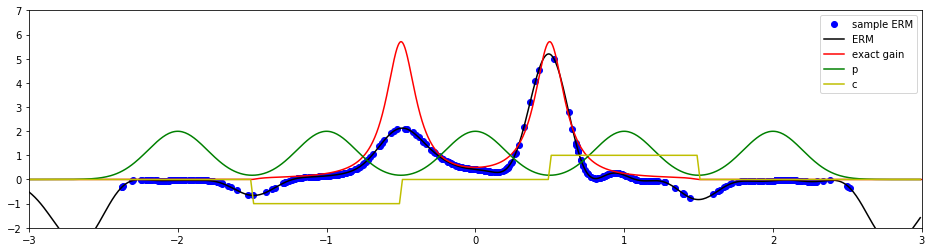

In [12]:
# plot
xx = np.arange(-3.0, 3.0, 0.01)

plt.figure(1)
plt.figure(figsize=(16,4))
plt.xlim((-3,3))
plt.ylim((-2,7))
plt.plot(
    x, [Gain_ERM(y,x,beta) for y in x], 'bo', 
    xx, [Gain_ERM(y,x,beta) for y in xx], 'k', 
    exactgain[:,0], exactgain[:,1],'r',
    xx, [5*p(y) for y in xx], 'g',
    xx, [c(y) for y in xx], 'y'
)
plt.legend(['sample ERM','ERM','exact gain','p','c'])